This notebook displays applications of Deep Learning Convolutional Neural Networks and Simple Neural Networks 

for Multi Zipcodes Classification based on Timestamp and GeoAnalysis for Parking Citation

1) the work is also inspired from Breeze's great analysis:

https://github.com/hackforla/lucky-parking/blob/master/notebooks/one-hot%20encode_DNN2.ipynb

2) Since Deep Learning consumes huge memory space, data is first processed and saved as pickle file

3) Train and Validation split is based on ascending Issue Date

4) Both simple CNN+NN blocks are implemented with BatchNorm, Dropout, Initializers

5) Early stopping is limited to 1 or 3 only; no learning rate reduction applied due to time constraint

6) Still, both validation loss and accuracy are improving

7) So far no overfitting issue detected; only tiny discrepancy for loss+accuracy between train and validation sets

8) 1st iteration for CNN: train_loss: 0.1578 - train_accuracy: 0.9300, val_loss: 0.0554 - val_accuracy: 0.9782

9) 1st iteration for NN: train_loss: 0.4843 - train_accuracy: 0.7966, val_loss: 0.1478 - val_accuracy: 0.9480

10) 2nd or best iteration for CNN: train_loss: 0.0765 - train_accuracy: 0.9680, val_loss: 0.0499 - val_accuracy: 0.9798

11) 3rd or best iteration for NN: train_loss: 0.0936 - train_accuracy: 0.9666, val_loss: 0.0684 - val_accuracy: 0.9753

13) This is only the first round of Deep Learning implementation and the result can be improved by higher early stopping, setting learning rate reduction, tuning hyperparameters, trying out different model structures and applications,...

In [2]:
#machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc,roc_auc_score
from catboost import CatBoostClassifier,Pool, cv
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import time
sns.set()
%matplotlib inline
import geopandas
from geopandas import GeoDataFrame
from shapely.geometry import Point
import pyproj

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Deep Learning Libraries
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.layers import Conv1D,MaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import callbacks

In [4]:
# Load dataset
final_sdf = pd.read_pickle('../input/final-sdf-data/final_sdf.pkl')

In [5]:
final_sdf['Zip_Num']=final_sdf['Zip_Num'].map({
90042:0,
90041:1,
90065:2,
90031:3,
90032:4,
})
final_sdf['Zip_Num']=final_sdf['Zip_Num'].astype('int32')

In [6]:
final_sdf.sort_values(by=['Issue Date'], inplace=True, ascending=True)

In [7]:
final_sdf.drop(['Issue Date'], axis=1, inplace=True)

In [8]:
X = final_sdf.drop(labels=['Zip_Num'], axis=1)
y = final_sdf['Zip_Num'].values

Here, we slice dataframe into train and validataion sets by ascending Issue Date

We can also try many other options such as StratifiedKFold, KFold,....

In [9]:
X_train = X[:153913]
X_cv = X[153913:]
y_train = y[:153913]
y_cv = y[153913:]
print(X_train.shape, X_cv.shape, y_train.shape, y_cv.shape)

(153913, 104) (38470, 104) (153913,) (38470,)


In [10]:
X_train = X_train.to_numpy()
X_cv = X_cv.to_numpy()

In [11]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_cv = X_cv.reshape(X_cv.shape[0],X_cv.shape[1],1)

In [12]:
# Convolutional Neural Networks (CNN)
epoch = 40
model = Sequential()
model.add(Conv1D(40,2,activation='elu',kernel_initializer='he_normal',input_shape = X_train[0].shape))
model.add(BatchNormalization())

model.add(Conv1D(70,2,activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv1D(100,2,activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv1D(100,2,activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64,activation='elu', kernel_initializer='he_normal'))

model.add(Dense(5,activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 103, 40)           120       
_________________________________________________________________
batch_normalization (BatchNo (None, 103, 40)           160       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 102, 70)           5670      
_________________________________________________________________
batch_normalization_1 (Batch (None, 102, 70)           280       
_________________________________________________________________
dropout (Dropout)            (None, 102, 70)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 101, 100)          14100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 101, 100)          4

In [14]:
model.compile(optimizer=Adam(lr=0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
earlystop = EarlyStopping(patience=1) # definitely should be set higher for better performance
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                            patience=2, 
#                                            verbose=1, 
#                                            factor=0.88, 
#                                            min_lr=0.00001)
callbacks = [earlystop, #learning_rate_reduction
            ]
# Not including learning_rate_reduction here due to time constraint 

In [16]:
history = model.fit(X_train, y_train, epochs=epoch, 
                    validation_data=(X_cv, y_cv), 
                    callbacks=callbacks,verbose=1)

Train on 153913 samples, validate on 38470 samples
Epoch 1/40
153913/153913 [==============================] - 173s 1ms/sample - loss: 0.1578 - accuracy: 0.9300 - val_loss: 0.0554 - val_accuracy: 0.9782
Epoch 2/40
153913/153913 [==============================] - 175s 1ms/sample - loss: 0.0765 - accuracy: 0.9680 - val_loss: 0.0499 - val_accuracy: 0.9798
Epoch 3/40
  7520/153913 [>.............................] - ETA: 2:41 - loss: 0.0586 - accuracy: 0.9743

In [17]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

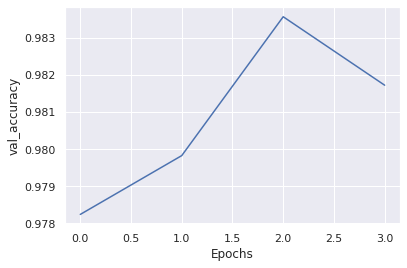

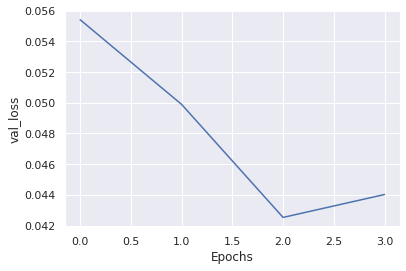

In [18]:
plot_graphs(history, 'val_accuracy')
plot_graphs(history, 'val_loss')

In [19]:
# Neural Networks Only
epoch = 40
model = Sequential()
model.add(Dense(70,activation='elu',kernel_initializer='he_normal',input_shape = X_train[0].shape))
model.add(BatchNormalization())

model.add(Dense(130,activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.45))

model.add(Dense(200,activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.55))

model.add(Dense(130,activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(60,activation='elu', kernel_initializer='he_normal'))

model.add(Dense(5,activation='softmax'))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 104, 70)           140       
_________________________________________________________________
batch_normalization_4 (Batch (None, 104, 70)           280       
_________________________________________________________________
dense_3 (Dense)              (None, 104, 130)          9230      
_________________________________________________________________
batch_normalization_5 (Batch (None, 104, 130)          520       
_________________________________________________________________
dropout_2 (Dropout)          (None, 104, 130)          0         
_________________________________________________________________
dense_4 (Dense)              (None, 104, 200)          26200     
_________________________________________________________________
batch_normalization_6 (Batch (None, 104, 200)         

In [21]:
model.compile(optimizer=Adam(lr=0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
earlystop = EarlyStopping(patience=3) # definitely should be set higher for better performance
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                            patience=2, 
#                                            verbose=1, 
#                                            factor=0.85, 
#                                            min_lr=0.00001)
callbacks = [earlystop, #learning_rate_reduction
            ]

In [23]:
history = model.fit(X_train, y_train, epochs=epoch, 
                    validation_data=(X_cv, y_cv), 
                    callbacks=callbacks,verbose=1)

Train on 153913 samples, validate on 38470 samples
Epoch 1/40
153913/153913 [==============================] - 238s 2ms/sample - loss: 0.4843 - accuracy: 0.7966 - val_loss: 0.1478 - val_accuracy: 0.9480
Epoch 2/40
153913/153913 [==============================] - 235s 2ms/sample - loss: 0.1367 - accuracy: 0.9500 - val_loss: 0.1096 - val_accuracy: 0.9511
Epoch 3/40
153913/153913 [==============================] - 235s 2ms/sample - loss: 0.0936 - accuracy: 0.9666 - val_loss: 0.0684 - val_accuracy: 0.9753
Epoch 4/40
153913/153913 [==============================] - 234s 2ms/sample - loss: 0.0819 - accuracy: 0.9712 - val_loss: 1.1604 - val_accuracy: 0.6592
Epoch 5/40
128256/153913 [=======================>......] - ETA: 36s - loss: 0.0546 - accuracy: 0.9816

In [24]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

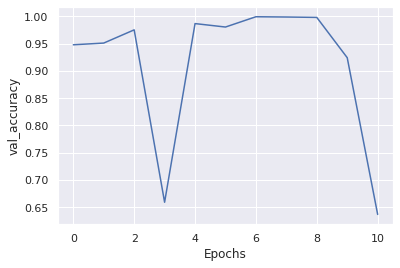

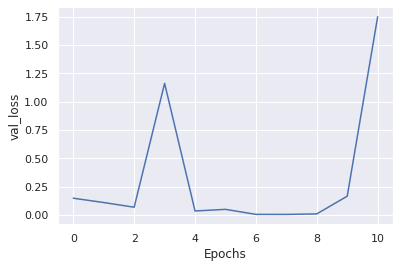

In [25]:
plot_graphs(history, 'val_accuracy')
plot_graphs(history, 'val_loss')